In [1]:
import sys
sys.path.append('../src')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

from tensorflow.keras import Sequential, Input, layers
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow_addons.metrics import FBetaScore

# from tensorflow.keras.metrics import Recall, Precision

from utils.data import get_best_slice, select_tomo_ids, get_csv_from_bq
from utils.render_motor_position import get_motor_coordinates, get_slice_file_path

/Users/wm/.pyenv/versions/3.10.6/envs/byu/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/wm/.pyenv/versions/3.10.6/envs/byu/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter 

In [2]:
path_train_csv= '../data/csv_raw/train_labels.csv'
# path_image= '../data/pictures_raw/train'
path_image = '../data/pictures_process/adaptequal_1_padded'

df = pd.read_csv(path_train_csv).copy()
df#['tomo_id']== ''

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors
0,0,16,tomo_049310,-1.0,-1.0,-1.0,500,924,956,19.7,0
1,1,30,tomo_098751,-1.0,-1.0,-1.0,500,924,956,16.1,0
2,2,54,tomo_136c8d,-1.0,-1.0,-1.0,500,924,956,19.7,0
3,3,59,tomo_146de2,-1.0,-1.0,-1.0,500,924,956,16.1,0
4,4,84,tomo_1dc5f9,-1.0,-1.0,-1.0,500,924,956,19.7,0
...,...,...,...,...,...,...,...,...,...,...,...
732,732,99,tomo_226cd8,366.0,693.0,269.0,500,928,960,13.1,10
733,733,100,tomo_226cd8,386.0,693.0,319.0,500,928,960,13.1,10
734,734,101,tomo_226cd8,388.0,671.0,433.0,500,928,960,13.1,10
735,735,102,tomo_226cd8,411.0,318.0,740.0,500,928,960,13.1,10


In [3]:
# pd.serie with list of tomo (tomo_2dd6bd)
tomogram_id= select_tomo_ids(df,
                             number_of_slices= list(df['Array_shape_axis_0'].unique()) #[500, 800, 600, 300, 400, 494]
                             )
tomogram_id

# '''
# prendre les photos paddé adaptequal1
# prendre toutes les q de slice
# list(df['Array_shape_axis_0'].unique)
# '''

0      tomo_049310
1      tomo_098751
2      tomo_136c8d
3      tomo_146de2
4      tomo_1dc5f9
          ...     
594    tomo_f78e91
595    tomo_f871ad
596    tomo_fc3c39
597    tomo_fc5ae4
598    tomo_fd5b38
Name: tomo_id, Length: 578, dtype: object

In [4]:


def load_images_by_ids(folder_path, tomo_ids, color_mode='grayscale', target_size=None):
    images = []
    folder = Path(folder_path)

    for tomo_id in tomo_ids:
        img_file = folder / f"{tomo_id}.jpg"
        if img_file.exists():
            img = load_img(img_file, color_mode=color_mode, target_size=target_size)
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
        else:
            print(f"[⚠️] Imagen no encontrada: {img_file}")

    return np.array(images)

folder_path = '../data/pictures_process/adaptequal_1_padded'
X = load_images_by_ids(folder_path, tomogram_id)


In [5]:
df_filtered = df[df['tomo_id'].isin(tomogram_id)]
y = df_filtered['Number_of_motors']


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test_kaggel, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [8]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall
import tensorflow as tf
from tensorflow_addons.metrics import FBetaScore

def init_model_densenet(X):
    original_input_shape = X.shape[1:]

    # Forzar input a 3 canales si es gris (1 canal)
    if original_input_shape[-1] == 1:
        base_input_shape = original_input_shape[:-1] + (3,)
    else:
        base_input_shape = original_input_shape

    # Cargar modelo base DenseNet121 sin la capa de clasificación final
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=base_input_shape)
    base_model.trainable = False

    # Input layer
    inputs = Input(shape=original_input_shape)

    # Convertir a RGB si es necesario
    if original_input_shape[-1] == 1:
        x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(inputs)
    else:
        x = inputs

    # Aplicar modelo base
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    # Compilar
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=[
            'accuracy',
            FBetaScore(num_classes=1, average='micro', beta=2.0),
            Recall()
        ]
    )

    return model

def model_train (model, X_train_processed, y_train, batch_size=16 ,epochs=5):
    verbose=1
    validation_split=0.1
    es = EarlyStopping(patience=3,
                       restore_best_weights=True)

    history = model.fit(X_train_processed,
                        y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        # validation_split=validation_split,
                        validation_data=(X_val, y_val),
                        callbacks=[es],
                        verbose=verbose)
    return history




model_densenet = init_model_densenet(X_train)
history_densenet = model_train(model_densenet, X_train,y_train)
history_densenet

Epoch 1/5


2025-06-05 17:52:46.146854: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


30/30 [==============================] - 359s 12s/step - loss: 0.8922 - accuracy: 0.4573 - fbeta_score: 0.8631 - recall_1: 0.4751 - val_loss: 0.8098 - val_accuracy: 0.4423 - val_fbeta_score: 0.7986 - val_recall_1: 1.0000
Epoch 2/5
30/30 [==============================] - 386s 13s/step - loss: 0.7508 - accuracy: 0.5342 - fbeta_score: 0.8631 - recall_1: 0.6820 - val_loss: 0.7049 - val_accuracy: 0.5962 - val_fbeta_score: 0.7986 - val_recall_1: 1.0000
Epoch 3/5
30/30 [==============================] - 6616s 214s/step - loss: 0.6103 - accuracy: 0.6645 - fbeta_score: 0.8631 - recall_1: 0.7625 - val_loss: 0.6506 - val_accuracy: 0.6731 - val_fbeta_score: 0.7986 - val_recall_1: 0.9565
Epoch 4/5
30/30 [==============================] - 3588s 102s/step - loss: 0.6102 - accuracy: 0.6795 - fbeta_score: 0.8631 - recall_1: 0.7663 - val_loss: 0.6607 - val_accuracy: 0.6923 - val_fbeta_score: 0.7986 - val_recall_1: 0.9565
Epoch 5/5
30/30 [==============================] - 317s 11s/step - loss: 0.5717 - 

In [9]:
model_densenet.evaluate(X_test_kaggel,y_test)

2/2 [==============================] - 33s 13s/step - loss: 0.5588 - accuracy: 0.7241 - fbeta_score: 0.8333 - recall_1: 0.9655


[0.5588293671607971,
 0.7241379022598267,
 0.8333333730697632,
 0.9655172228813171]

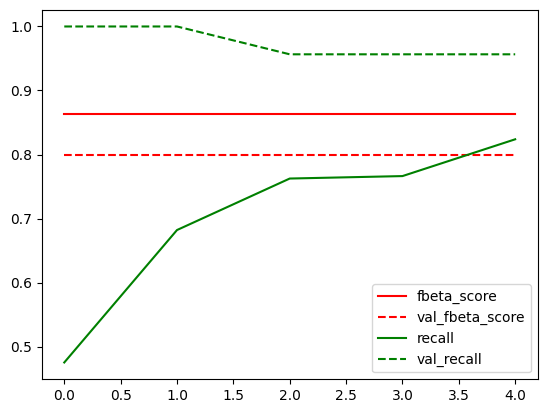

In [12]:
history_densenet.history


plt.plot(history_densenet.history['fbeta_score'], c='r', label="fbeta_score")
plt.plot(history_densenet.history['val_fbeta_score'], c='r', linestyle='--', label="val_fbeta_score")

# plt.plot(history_densenet.history['accuracy'],c='black', label="accuracy")
# plt.plot(history_densenet.history['val_accuracy'],c='black', linestyle='--', label="val_accuracy")


plt.plot(history_densenet.history['recall_1'], c= 'g', label="recall");
plt.plot(history_densenet.history['val_recall_1'], c= 'g', linestyle='--', label="val_recall");

# plt.plot(history.history['precision'], c='g');
# plt.plot(history.history['val_precision'], c='b');

plt.legend()

In [ ]:
from sklearn.metrics import fbeta_score

y_pred= model_densenet.predict(X_test_kaggel )
fbeta_score(y_test, y_pred, beta=2, average='binary')



2/2 [==============================] - 31s 12s/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets